## Full Pipeline for UDA Project

In this jupyter notebook you should be able to run the entire pipeline end to end from web scraping, preprocessing and analysis. There is a requirements.txt in the codebase and README.

## Webscraping/Data Collection

Bank of England Minutes text data is extracted from the website, parsed using Beautiful Soup ready for analysis. Asset price data is also pulled and processed for comparison.

In [2]:
import time
import requests
from bs4 import BeautifulSoup
import pandas as pd

BASE_URL = "https://www.bankofengland.co.uk"

headers = {
    "User-Agent": "Mozilla/5.0 (compatible; academic-research/1.0)"
}

def build_mpsm_url(year, month_name):
    """
    Build URL like:
    https://www.bankofengland.co.uk/monetary-policy-summary-and-minutes/2025/august-2025
    """
    month_slug = month_name.lower()
    return f"{BASE_URL}/monetary-policy-summary-and-minutes/{year}/{month_slug}-{year}"

def fetch_html(url):
    """
    Fetch a page with basic error handling.
    Returns HTML text or None if not found / request failed.
    """
    try:
        resp = requests.get(url, headers=headers, timeout=20)
        if resp.status_code == 404:
            print(f"404 (not found): {url}")
            return None
        resp.raise_for_status()
        return resp.text
    except requests.exceptions.RequestException as e:
        print(f"Request failed for {url}: {e}")
        return None

def extract_minutes_from_soup(soup: BeautifulSoup):
    """
    Extract title, date, and main text from a BoE MPC minutes page.
    You can tweak selectors if needed after inspecting a page.
    """
    # Title (usually in <h1>)
    title_el = soup.find("h1")
    title = title_el.get_text(strip=True) if title_el else ""

    # Main content
    main = (
        soup.select_one("[role='main']")
        or soup.select_one(".article-body")
        or soup.select_one(".content")
        or soup.body
    )



    for tag in main.find_all(["nav", "aside", "footer", "script", "style"]):
        tag.decompose()

    text = main.get_text(separator="\n", strip=True)

    return {
        "title": title,
        "text": text,
    }


months = [
    "january", "february", "march", "april",
    "may", "june", "july", "august",
    "september", "october", "november", "december",
]

start_year = 2020      
end_year = 2025           
sleep_sec = 1.0            

rows = []

for year in range(start_year, end_year + 1):
    for month in months:
        url = build_mpsm_url(year, month)
        print(f"Trying {url} ...")
        html = fetch_html(url)
        if html is None:
            continue

        soup = BeautifulSoup(html, "lxml")
        info = extract_minutes_from_soup(soup)
        info.update({
            "year": year,
            "month": month,
        })
        rows.append(info)
        print(f"  -> OK: {info['title'][:80]!r}")

        time.sleep(sleep_sec)

len(rows)
df = pd.DataFrame(rows)
df["text"] = df["text"].str.replace(r"\s+", " ", regex=True).str.strip()
df.to_csv("boe_mpc_minutes_2020-2025.csv", index=False)

Trying https://www.bankofengland.co.uk/monetary-policy-summary-and-minutes/2020/january-2020 ...
  -> OK: 'Bank Rate maintained at 0.75% - January 2020'
Trying https://www.bankofengland.co.uk/monetary-policy-summary-and-minutes/2020/february-2020 ...
404 (not found): https://www.bankofengland.co.uk/monetary-policy-summary-and-minutes/2020/february-2020
Trying https://www.bankofengland.co.uk/monetary-policy-summary-and-minutes/2020/march-2020 ...
  -> OK: 'Bank Rate maintained at 0.1% - March 2020'
Trying https://www.bankofengland.co.uk/monetary-policy-summary-and-minutes/2020/april-2020 ...
404 (not found): https://www.bankofengland.co.uk/monetary-policy-summary-and-minutes/2020/april-2020
Trying https://www.bankofengland.co.uk/monetary-policy-summary-and-minutes/2020/may-2020 ...
  -> OK: 'Bank Rate maintained at 0.1% - May 2020'
Trying https://www.bankofengland.co.uk/monetary-policy-summary-and-minutes/2020/june-2020 ...
  -> OK: 'Bank Rate maintained at 0.1% and asset purchases incr

In [4]:

# load in MPC_NLP_data 
asset_prices = pd.read_excel("data/MPC_NLP_data.xlsx", sheet_name = "surprises")
# filter for greater than August 2015 as this is our window
asset_prices = asset_prices[asset_prices['Datetime'] >= '2015-08-01']
asset_prices.head(5)

# create asset_prices_MPC which is only where isMPC == True indicating MPC minutess 
asset_prices_MPC = asset_prices[asset_prices['isMPC'] == True]

columns_subset = ["Datetime", "GBP3MOIS=", "GBP1YOIS=", "GBP3YOIS=", "GB1YT=RR", "GB5YT=RR", ".FTSE", "GBP="]
asset_prices_MPC = asset_prices_MPC[columns_subset]

asset_prices_MPC.tail(5)

# Merge asset_prices_MPC with df on date
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'], format='%Y-%B')
df['year_month'] = df['date'].dt.to_period('M')
asset_prices_MPC['year_month'] = asset_prices_MPC['Datetime'].dt.to_period('M')
df = pd.merge(df, asset_prices_MPC, left_on='year_month', right_on='year_month', how='left')
df = df.drop(columns=['year_month', 'Datetime'])

## Data Preprocessing

Before analysis can proceed, standard text preprocessing is required for most methods. The text_clean column is created which is processed and cleaned ready for analysis. We also drop domanin specifc stopwords like "meeting" "mintues" that were disturbing frequency measures and carry no policy meaning. For advanced methods like the transformer later on we use the raw text.

In [ ]:
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

## Uncomment if needed for download
# nltk.download("wordnet")
# nltk.download("punkt")
# nltk.download("punkt_tab")
# nltk.download("stopwords")

# Make sure `text` is string
df["text"] = df["text"].astype(str)

# custom stopwords for monetary policy context
custom_stopwords = [
    "bank", "rate", "interest", "monetary", "policy", "mpc", "minute", "meeting", "decision", "committee", "level", "percent",
    "percentage", "economic", "related", "link", "financial", "market", "summary", "report", "england", "pdf",
    "uk", "united", "kingdom", "published", "cpi",
    "january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december",
]

# Remove text from title to avoid leakage
def preprocess_text(doc):
    """Preprocess the input text by:
    - lowercasing
    - tokenizing 
    - removing non-alphabetic tokens, 
    - removing stopwords
    - stemming
    - """
    # lowercase
    doc = doc.lower()
    # tokenize
    tokens = word_tokenize(doc)
    # remove numbers, punctuation
    tokens = [t for t in tokens if t.isalpha()]
    # lemmatization
    # lemmatizer = nltk.WordNetLemmatizer()
    # tokens = [lemmatizer.lemmatize(t) for t in tokens]
    # remove stopwords
    stop_words = set(stopwords.words("english")) | set(custom_stopwords)
    tokens = [t for t in tokens if t not in stop_words]

    return " ".join(tokens)


df["text_clean"] = df["text"].apply(preprocess_text)

# ]original vs cleaned text
df[["text", "text_clean"]].head()

,text,text_clean
0,Bank Rate maintained at 0.75% - January 2020 O...,maintained voted majority maintain also voted ...
1,Bank Rate maintained at 0.1% - March 2020 Our ...,maintained voted unanimously maintain also vot...
2,Bank Rate maintained at 0.1% - March 2020 Our ...,maintained voted unanimously maintain also vot...
3,Bank Rate maintained at 0.1% - May 2020 Our MP...,maintained voted unanimously maintain voted ma...
4,Bank Rate maintained at 0.1% and asset purchas...,maintained asset purchases increased minutes l...


## Feature Extraction 

For the analysis, it is helpful to extract some features from the text and alternate marcoeconomic sources and join them to the data. For example, it is useful to extract the interest rate decision made at the meeting as it is a key characterstic to analyse text againist and also control for later. 

In [ ]:
# 
#Create features from txt 
#Extract Bank Rate % as new column by searching for patterns like "Bank Rate ... 5.25%"
from matplotlib import text

def extract_new_interest_rate(text):
    """Extract Bank Rate percentage and decision (increase/decrease/maintained) from text.
    Looks for patterns like 'Bank Rate ... 5.25%'."""
    pattern = r"Bank Rate[^\d]*(\d{1,2}\.\d{1,2}|\d{1,2})%"
    match = re.search(pattern, text)
    if match:
        return float(match.group(1))
    return np.nan

df["bank_rate_pct"] = df["title"].apply(extract_new_interest_rate)

def extract_decision_direction(text):
    """Extract decision direction (increase/decrease/maintained) from text."""
    if re.search(r"increased", text, re.IGNORECASE):
        return "increase"
    elif re.search(r"decreased | reduced", text, re.IGNORECASE):
        return "decrease"
    elif re.search(r"maintain|held", text, re.IGNORECASE):
        return "maintained"
    return "unknown"

df["decision"] = df["title"].apply(extract_decision_direction)
df["text_clean"].iloc[2]

# save to CSV
df.to_csv("data/boe_mpc_minutes_2020-2025_enhanced.csv", index=False)

NameError: name 'df' is not defined

### Basic NLP and word embedding

We begin with standard bag of words embedding and frequency counts to get a sense of frequently used words, similarly we use bi-grams and TF-IDF embedding to analyse patterns in common phrases used depending on the interest rate decision made at the meeting. Finally Word2vec embedding is trained and evaluated through cosine similarity of key words in the monetary policy domain. 

In [ ]:
# Use a simple Bag of Words Count vectoriser to begin with to find most common words by decision

from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_features=200)  
X_counts = count_vectorizer.fit_transform(df["text_clean"]).toarray()
MPC_vocab = count_vectorizer.get_feature_names_out()

def top_words_by_decision(decision, n=10):
    """Get the most frequently used words in the minutes for a given decision direction"""
    counts = np.asanyarray(X_counts[df["decision"] == decision].sum(axis=0)).flatten()
    top_indices = counts.argsort()[-n:][::-1]
    top_words = [(MPC_vocab[i], counts[i]) for i in top_indices]
    return top_words

top_words_raise = top_words_by_decision("increase", n=10)
top_words_reduce = top_words_by_decision("decrease", n=10)
top_words_maintain = top_words_by_decision("maintained", n=10)

print("Top words when decision was to INCREASE rates:")
print(top_words_raise)
print("\nTop words when decision was to DECREASE rates:")
print(top_words_reduce)
print("\nTop words when decision was to MAINTAIN rates:")
print(top_words_maintain)

Top words when decision was to INCREASE rates:
[('inflation', 1090), ('expected', 545), ('prices', 481), ('growth', 410), ('around', 395), ('would', 391), ('price', 369), ('remained', 308), ('target', 302), ('energy', 280)]

Top words when decision was to DECREASE rates:
[('inflation', 313), ('growth', 127), ('expected', 101), ('risks', 89), ('target', 79), ('members', 74), ('would', 74), ('could', 72), ('around', 72), ('continued', 68)]

Top words when decision was to MAINTAIN rates:
[('inflation', 1186), ('growth', 541), ('expected', 441), ('target', 346), ('remained', 342), ('prices', 339), ('would', 333), ('around', 310), ('continued', 296), ('labour', 287)]


In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
bigram_vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=100)
bigram_X = bigram_vectorizer.fit_transform(df["text_clean"]).toarray()

from collections import defaultdict
bigram_counts_by_decision = defaultdict(lambda: np.zeros(len(bigram_vectorizer.get_feature_names_out()), dtype=int))
for decision in df["decision"].unique():
    subset_indices = df.index[df["decision"] == decision].tolist()
    bigram_counts_by_decision[decision] = bigram_X[subset_indices].sum(axis=0)
for decision, counts in bigram_counts_by_decision.items():
    top_indices = counts.argsort()[-10:][::-1]
    top_bigrams = [(bigram_vectorizer.get_feature_names_out()[i], counts[i]) for i in top_indices]
    print(f"Top bigrams when decision was to {decision.upper()}:")
    print(top_bigrams)
    print()

Top bigrams when decision was to MAINTAINED:
[('price inflation', 4.7756966588747725), ('inflation target', 4.263944127124188), ('bond purchases', 4.097045486777361), ('central reserves', 4.0870320611616995), ('government bond', 3.834939886250777), ('financed issuance', 3.6328835895437086), ('issuance central', 3.6328835895437086), ('inflation expectations', 3.6187668245141578), ('spare capacity', 3.4022780942420696), ('news news', 3.086504114856873)]

Top bigrams when decision was to INCREASE:
[('price inflation', 3.2932131075814373), ('inflation target', 2.634571672650763), ('since previous', 2.58668066507821), ('inflationary pressures', 2.5248171921141194), ('inflation expectations', 2.504688004954051), ('euro area', 2.4700093248683817), ('energy prices', 2.466324098530051), ('medium term', 2.2250111015763765), ('three months', 2.1997886227308285), ('increase points', 2.1158606064098406)]

Top bigrams when decision was to DECREASE:
[('inflationary pressures', 1.7567605019528636), ('

In [ ]:
from gensim.models import Word2Vec
sentences = [text.split() for text in df["text_clean"]]

# train Word2Vec model
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=200,   
    window=5,          
    min_count=1,       
    workers=4,
    sg=0,             
    epochs=50,
)

# build a document embedding as the mean of word vectors
def doc_vector(text):
    tokens = text.split()
    vecs = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]
    if not vecs:
        return np.zeros(w2v_model.vector_size)
    return np.mean(vecs, axis=0)

X_w2v = np.vstack(df["text_clean"].apply(doc_vector))
X_w2v.shape


# words most similar to "inflation"
print(w2v_model.wv.most_similar("inflation", topn=5))


[('core', 0.4136801064014435), ('price', 0.3847792148590088), ('prices', 0.3561834394931793), ('stay', 0.3539412319660187), ('expectations', 0.35257863998413086)]


## Clustering
Now we have a word embedding that has effective vectorised our text data in word2vec, it is valueable to see if there is any clustering behaviour at the document (minutes) level. We can then compare these clusters of documents with tangible features we extracted earlier like decision type. Practically, as the embedding is high-dimensional, we employ principal component analysis (PCA) to project onto 2 dimension for visualisation purposes. A K-means clustering algorithim is then run with 3 clusters. There is interesting results when visualised with interest rate movement. 

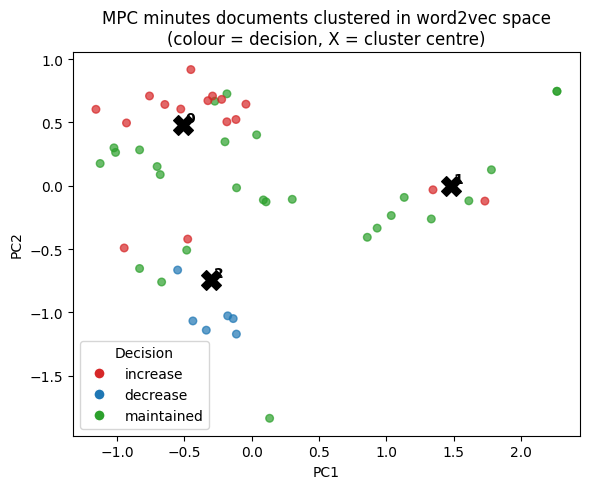

In [ ]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


pca = PCA(n_components=2, random_state=69)
X_2d = pca.fit_transform(X_w2v)
# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=69)
kmeans.fit(X_w2v)

# Try Hierchical Clustering as well
agglo = AgglomerativeClustering(n_clusters=3)
agglo.fit(X_w2v)

decision_colors = {
    "increase": "tab:red",
    "decrease": "tab:blue",
    "maintained": "tab:green",
    "unknown": "gray",
}
point_colors = df["decision"].map(decision_colors)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1],
            c=point_colors, s=30, alpha=0.7)
##
centers_2d = pca.transform(kmeans.cluster_centers_)
for i, (x, y) in enumerate(centers_2d):
    plt.scatter(x, y, c="black", marker="X", s=200)
    plt.text(x + 0.02, y + 0.02, str(i), fontsize=10, weight="bold")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("MPC minutes documents clustered in word2vec space\n(colour = decision, X = cluster centre)")
legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="increase",
           markerfacecolor="tab:red", markersize=8),
    Line2D([0], [0], marker="o", color="w", label="decrease",
           markerfacecolor="tab:blue", markersize=8),
    Line2D([0], [0], marker="o", color="w", label="maintained",
           markerfacecolor="tab:green", markersize=8),
]
plt.legend(handles=legend_elements, title="Decision", loc="best")

plt.tight_layout()
plt.show()

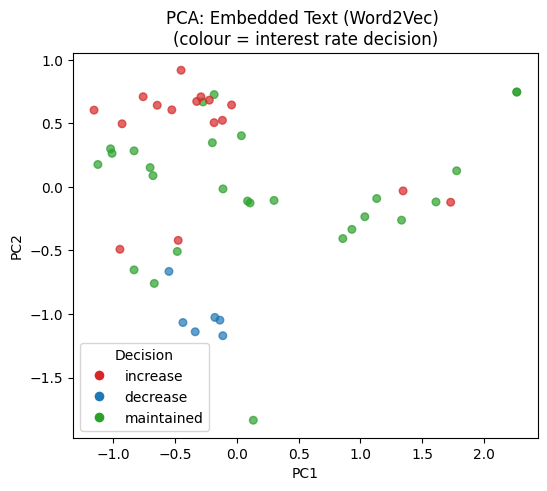

In [ ]:
#print figure without centroids 
plt.figure(figsize=(6, 5))
# points coloured by decision
plt.scatter(X_2d[:, 0], X_2d[:, 1],
            c=point_colors, s=30, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: Embedded Text (Word2Vec) \n(colour = interest rate decision)")
plt.legend(handles=legend_elements, title="Decision", loc="best")
plt.show()

# Transformer RoBERTa trained on Central Bank data
In this section, we explore the use of transformer based models on Bank of England text. Specifically we use a pre-trained RoBERTa transformer tuned specifically for central bank communications. We load the transformers packages and import the model from hugging face for our use. Then the sentiment-classifier is applied to each MPC minutes document to obtain probabilities each document text is "hawkish" or "dovish". These probabilties are netted against one another to calculate a net hawkish-dovish index (HDI). This is appended to the dataframe for analysis over time.

We can then link back to our asset price "surprises" or responses. Using HDI to predict the sign and/or magintude of surprise from text while controlling for decision. This explores whether the wording of the minutes contains information that markets trade on beyond just the rate decision.

In [ ]:
from transformers import RobertaTokenizer, RobertaModel, pipeline

data = df.copy()

sentiment_classifier = pipeline(
    "text-classification",
    model="Moritz-Pfeifer/CentralBankRoBERTa-sentiment-classifier",
    top_k=None,              # return all labels
    truncation=True
)


raw_scores = data["text_clean"].apply(
    lambda x: sentiment_classifier(x[:512])[0]
)

def hawkish_score(score_list):
    probs = {d["label"]: d["score"] for d in score_list}
    hawk = probs.get("hawkish", probs.get("positive", 0.0))
    dov  = probs.get("dovish",  probs.get("negative", 0.0))
    return hawk - dov           

data["hawkish_index"] = raw_scores.apply(hawkish_score)
data.head()

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,title,text,year,month,date,GBP3MOIS=,GBP1YOIS=,GBP3YOIS=,GB1YT=RR,GB5YT=RR,.FTSE,GBP=,text_clean,bank_rate_pct,decision,hawkish_index
0,Bank Rate maintained at 0.75% - January 2020,Bank Rate maintained at 0.75% - January 2020 O...,2020,january,2020-01-01,0.11680,0.08560,NaN,0.0810,0.0605,-0.413351,0.474806,maintained voted majority maintain also voted ...,0.75,maintained,0.176017
1,Bank Rate maintained at 0.1% - March 2020,Bank Rate maintained at 0.1% - March 2020 Our ...,2020,march,2020-03-01,-0.06175,-0.06110,NaN,-0.1320,-0.1540,1.282576,0.500739,maintained voted unanimously maintain also vot...,0.10,maintained,-0.000258
2,Bank Rate maintained at 0.1% - March 2020,Bank Rate maintained at 0.1% - March 2020 Our ...,2020,march,2020-03-01,-0.00220,-0.00420,NaN,-0.0035,-0.0045,-0.565351,-0.183808,maintained voted unanimously maintain also vot...,0.10,maintained,-0.000258
3,Bank Rate maintained at 0.1% - May 2020,Bank Rate maintained at 0.1% - May 2020 Our MP...,2020,may,2020-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,maintained voted unanimously maintain voted ma...,0.10,maintained,0.304164
4,Bank Rate maintained at 0.1% and asset purchas...,Bank Rate maintained at 0.1% and asset purchas...,2020,june,2020-06-01,0.00685,0.00995,NaN,0.0445,0.0480,-0.614421,0.095985,maintained asset purchases increased minutes l...,0.10,increase,0.373985


              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.57      0.57      0.57         7

    accuracy                           0.60        15
   macro avg       0.60      0.60      0.60        15
weighted avg       0.60      0.60      0.60        15



<Axes: >

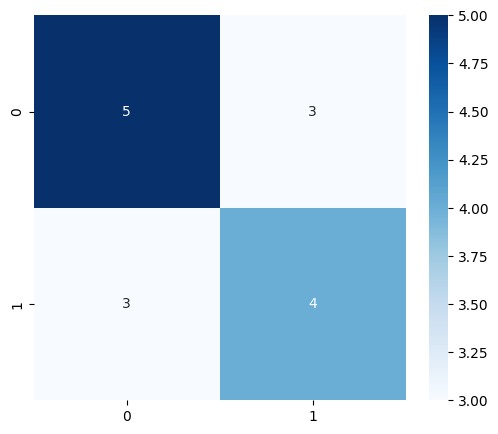

In [ ]:
# Create a classifier to predict hawkish vs dovish asset price movements based on hawkish_index
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


# create surprise_sign column: 1 if GBP3MOIS= > 0 else 0
data["surprise_sign"] = (data["GBP3MOIS="] > 0).astype(int)

X = data[["hawkish_index"]].values
y = data["surprise_sign"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=21
)

logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

# visualise confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=logreg.classes_)
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=logreg.classes_, yticklabels=logreg.classes_)

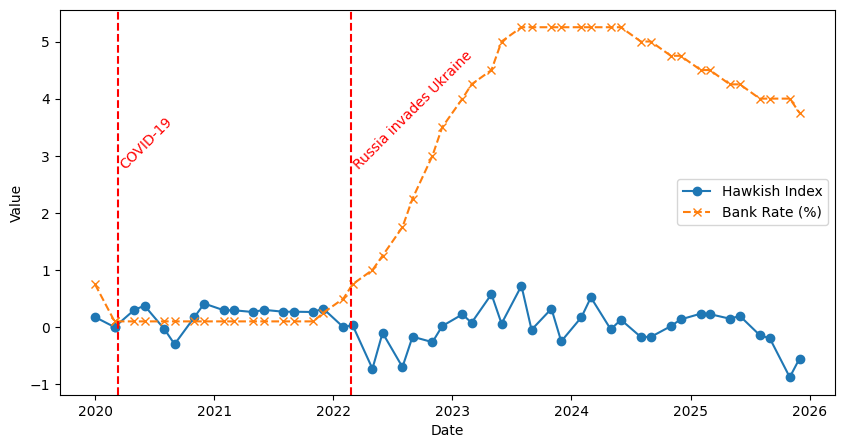

In [ ]:
# plot hawkish index over time against bank rate and inflation
import matplotlib.pyplot as plt
key_events = {
    "2020-03-11": "COVID-19",
    "2022-02-24": "Russia invades Ukraine",
}

plt.figure(figsize=(10, 5))
plt.plot(data['date'], data['hawkish_index'], marker='o', linestyle='-', label='Hawkish Index')
plt.plot(data['date'], data['bank_rate_pct'], marker='x', linestyle='--', label='Bank Rate (%)')
#plt.plot(data['date'], data['inflation'], marker='s', linestyle='-.', label='Inflation (%)')
plt.xlabel('Date')
plt.ylabel('Value')

for date_str, event in key_events.items():
    date = pd.to_datetime(date_str)
    plt.axvline(x=date, color='red', linestyle='--')
    plt.text(date, plt.ylim()[1]*0.5, event, rotation=45, color='red')

plt.legend()

plt.show()



In [ ]:
# Give me an example of a least hawkish MPC minute text
least_hawkish_idx = data["hawkish_index"].idxmin()
print(data.loc[least_hawkish_idx, "text"])


Bank Rate maintained at 4% - November 2025 Monetary Policy Summary and Minutes Find out more about the Monetary Policy Committee’s latest decision Related links Related links Our latest decision explained Monetary Policy Report - November 2025 Monetary Policy Summary and minutes of the Monetary Policy Committee meeting ending on 5 November 2025 ( PDF 0.3MB) PDF Close dialog Published on 06 November 2025 Monetary Policy Summary, November 2025 At its meeting ending on 5 November 2025, the Monetary Policy Committee voted by a majority of 5–4 to maintain Bank Rate at 4%. Four members voted to reduce Bank Rate by 0.25 percentage points, to 3.75%. CPI inflation is judged to have peaked. Progress on underlying disinflation continues, supported by the still restrictive stance of monetary policy. This is reflected in an easing of pay growth and services price inflation. Underlying disinflation is being underpinned by subdued economic growth and building slack in the labour market. Monetary poli